## Part 1 - 图像增广

In [1]:
%matplotlib inline
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

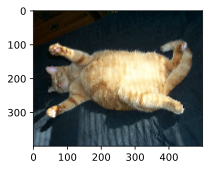

In [2]:
d2l.set_figsize()
img = Image.open('cat1.jpg')
d2l.plt.imshow(img)

In [3]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

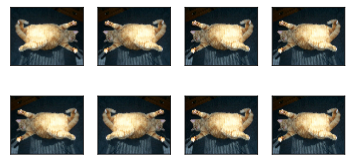

In [10]:
apply(img, torchvision.transforms.RandomHorizontalFlip())


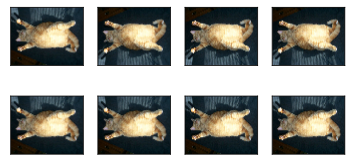

In [11]:
apply(img, torchvision.transforms.RandomVerticalFlip())

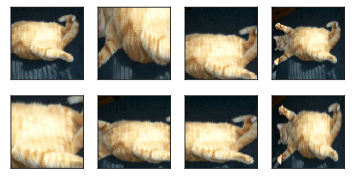

In [12]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)


Files already downloaded and verified
(32, 32)


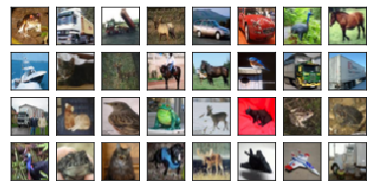

In [13]:
all_imges = torchvision.datasets.CIFAR10(train=True, root="~/Datasets/CIFAR", download=True)
# all_imges的每一个元素都是(image, label)
show_images([all_imges[i][0] for i in range(32)], 4, 8, scale=0.8);

print(all_imges[0][0].size)

In [24]:
flip_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.RandomVerticalFlip(),
     #torchvision.transforms.RandomCrop(18),
     #torchvision.transforms.RandomErasing(),
     torchvision.transforms.ToTensor()])

no_aug = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])


In [25]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size, root="~/Datasets/CIFAR"):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [26]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))


In [27]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)


In [28]:
train_with_data_aug(flip_aug, no_aug)


Files already downloaded and verified
Files already downloaded and verified
training on  cuda
epoch 1, loss 1.5575, train acc 0.429, test acc 0.382, time 22.2 sec
epoch 2, loss 0.6123, train acc 0.554, test acc 0.481, time 22.3 sec
epoch 3, loss 0.3552, train acc 0.620, test acc 0.451, time 22.4 sec
epoch 4, loss 0.2431, train acc 0.653, test acc 0.557, time 22.4 sec
epoch 5, loss 0.1792, train acc 0.682, test acc 0.560, time 22.4 sec
epoch 6, loss 0.1401, train acc 0.701, test acc 0.621, time 22.4 sec
epoch 7, loss 0.1127, train acc 0.721, test acc 0.661, time 22.5 sec
epoch 8, loss 0.0932, train acc 0.737, test acc 0.660, time 22.5 sec
epoch 9, loss 0.0789, train acc 0.750, test acc 0.693, time 22.7 sec
epoch 10, loss 0.0677, train acc 0.761, test acc 0.681, time 22.5 sec


## Part 2 - 微调（fine tuning）

In [29]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
data_dir = '/home/lh/Datasets'
os.listdir(os.path.join(data_dir, "hotdog")) # ['train', 'test']


['train', 'test']

In [32]:
train_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/test'))


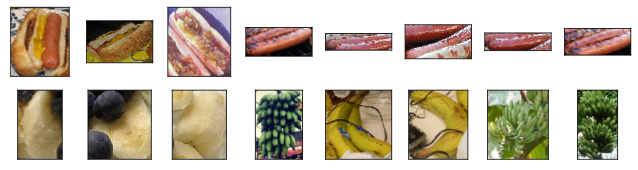

In [33]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);


In [34]:
# 指定RGB三个通道的均值和方差来将图像通道归一化
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])

In [35]:
pretrained_net = models.resnet18(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/lh/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [36]:
print(pretrained_net.fc)


Linear(in_features=512, out_features=1000, bias=True)


In [37]:
pretrained_net.fc = nn.Linear(512, 2)
print(pretrained_net.fc)


Linear(in_features=512, out_features=2, bias=True)


In [38]:
print(pretrained_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
output_params = list(map(id, pretrained_net.fc.parameters()))
feature_params = filter(lambda p: id(p) not in output_params, pretrained_net.parameters())

lr = 0.01
optimizer = optim.SGD([{'params': feature_params},
                       {'params': pretrained_net.fc.parameters(), 'lr': lr * 10}],
                       lr=lr, weight_decay=0.001)


In [40]:
def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=5):
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/train'), transform=train_augs),
                            batch_size, shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/test'), transform=test_augs),
                           batch_size)
    loss = torch.nn.CrossEntropyLoss()
    d2l.train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

train_fine_tuning(pretrained_net, optimizer)

training on  cuda
epoch 1, loss 3.4695, train acc 0.702, test acc 0.911, time 16.3 sec
epoch 2, loss 0.1717, train acc 0.911, test acc 0.925, time 16.1 sec
epoch 3, loss 0.0919, train acc 0.913, test acc 0.936, time 16.1 sec
epoch 4, loss 0.0436, train acc 0.938, test acc 0.931, time 16.2 sec
epoch 5, loss 0.0533, train acc 0.919, test acc 0.945, time 16.3 sec


In [41]:
scratch_net = models.resnet18(pretrained=False, num_classes=2)
lr = 0.1
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tuning(scratch_net, optimizer)

training on  cuda
epoch 1, loss 2.3744, train acc 0.637, test acc 0.757, time 16.2 sec
epoch 2, loss 0.2119, train acc 0.806, test acc 0.794, time 16.2 sec
epoch 3, loss 0.1231, train acc 0.838, test acc 0.815, time 16.2 sec
epoch 4, loss 0.0919, train acc 0.838, test acc 0.791, time 16.3 sec
epoch 5, loss 0.0687, train acc 0.854, test acc 0.821, time 16.2 sec


## Part 3 - 目标检测和边界框

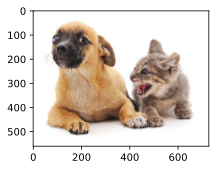

In [44]:
%matplotlib inline
from PIL import Image

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

d2l.set_figsize()
img = Image.open('./catdog.jpg')
d2l.plt.imshow(img);  # 加分号只显示图


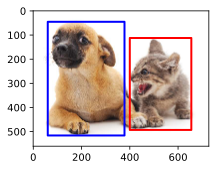

In [45]:
# bbox是bounding box的缩写
dog_bbox, cat_bbox = [60, 45, 378, 516], [400, 112, 655, 493]

def bbox_to_rect(bbox, color):  # 本函数已保存在d2lzh_pytorch中方便以后使用
    # 将边界框(左上x, 左上y, 右下x, 右下y)格式转换成matplotlib格式：
    # ((左上x, 左上y), 宽, 高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));
